#Introduction to (why I love) Julia: Part 3 - Calling C and Python
I wont lie. I haven't yet properly used these capabilities besides plotting a few things with PyPlot module. But have have written a Mex function in Matlab (a gateway function that bridges C and Matlab so that you can call C code from within Matlab) and this isn't a straightforward process, nor is it easy in Python. Also in my current field of research (X-ray Crystallography) pretty much all of the software libraries are written in C/C++ with Python bindings.   

So not having to reinvent the wheel and write these libraries again would appeal to lots of people... if it's easy that is. I'm here to tell you that I haven't come across language bridging simpler than Julia's APIs and I'm going to show you.   

The content here is copied from the IJulia notebook on the JuliaBox tutorial but it gets the point across anyway.

###Calling C (and Fortran) from Julia
######(For the Calling C part I will go to the tutorial online because I don't have the required libraries)
But here's a brief example where we call the clock function from the standard C library

In [1]:
ccall(:clock, Int32, ())

9388

### Calling Python from Julia

Thanks to a package called `PyCall`, Julia **call arbitrary Python** functions by calling directly into CPython's `libpython`:

In [2]:
using PyCall

In [3]:
@pyimport math as pymath

In [4]:
pymath.cos(3)

-0.9899924966004454

## Low-level dissection of a Python call

Let's break this down.  When you run `pymath.sin(3)`, Julia:

* First converts `3` into the corresponding Python object via `PyObject(3)`.
* Then calls `pymath.sin` via the `libpython` routine `PyObject_Call`.
* Finally, detects the type of the return value and converts it back to a Julia object.

###Some other more useful examples

In [5]:
@pyimport numpy as np
x = [-100, 39, 59, 55, 20]
np.irr(x)

0.2809484211599611

By default, PyCall makes a copy of arrays when converting from Python back to Julia:

In [6]:
np.cumsum(x)

5-element Array{Int64,1}:
 -100
  -61
   -2
   53
   73

But we can specify a copy-free return if desired by calling the lower-level `pycall` function and specifying the desired return type as `PyArray`:

In [ ]:
xsum = pycall(np.pymember("cumsum"), PyArray, x)

The resulting *NumPy* array can be passed to other Julia routines without making a copy:

In [ ]:
mean(xsum)

There is also a `PyVector` type that you can use to wrap **Python lists** without making a copy:

In [ ]:
syspath = pyimport("sys")["path"]

In [ ]:
syspath_julia = PyVector(syspath)

### Passing dictionaries

There is also a `PyDict` type that you can use to **share a dictionary** between Julia and Python.

In [ ]:
d = PyDict()

In [ ]:
d["hello"] = 7
d[23] = "goodbye"
d

For fun, we'll use `pyeval` to pass `d` as a local variable `dict` to an arbitrary string of Python code that we want to evaluate, in this case a list comprehension in Python:

In [ ]:
pyeval("[x for x in dict.keys()]", dict=d)

## Passing Julia functions to Python

Arbitrary Julia functions can be passed to Python.   They get converted into callable Python objects of a custom class, whose `__call__` method executes the Julia code:

In [ ]:
foo(x) = x + 1
pyfoo = PyObject(foo)

In [ ]:
pycall(pyfoo, PyAny, 17)

This is extremely useful for calling functions for optimization, root-finding, etcetera, from SciPy.  For example, let's solve a transcendental equation to find a root of $f(x) = \cos(x) - x$:

In [ ]:
@pyimport scipy.optimize as so
function f(x)
    println("   calling f($x)")
    cos(x) - x
end
so.newton(f, 1.2)

There is a bit of magic going on in passing Julia functions to Python.  To define a new Python type from the CPython API, we create a C `PyTypeObject` struct, and we need to stick a C function pointer into its `tp_call` slot to give it a `__call__` method.  

A *C function pointer is just the address of the compiled machine instructions,* and since Julia has these instructions from its JIT compiler it can give you the address of the instructions using an intrinsic called `cfunction`, e.g.

In [ ]:
cfunction(f, Float64, (Float64,))

This ability to get C function pointers from Julia functions is the key to calling **any C API expecting a callback routine**, not just Python.  See the blog post: [Passing Julia Callback Functions to C](http://julialang.org/blog/2013/05/callback/).

## Calling Matplotlib

To get Matplotlib working in IJulia, we had to do a bit more work, similar to what IPython had to do to get its `pylab` option working.   For GUI windows, we had to implement the GUI event loop for the Python GUI toolkit(s) (PyQt, Gtk, wx) in Julia.  For inline plots, we had to monkey-patch Matplotlib to intercept its drawing commands queue the figure for rendering as an image to be sent to the front-end.  All of this is done by the `PyPlot` Julia module:

In [3]:
using PyPlot

Qt: Untested Windows version 10.0 detected!
INFO: Loading help data...


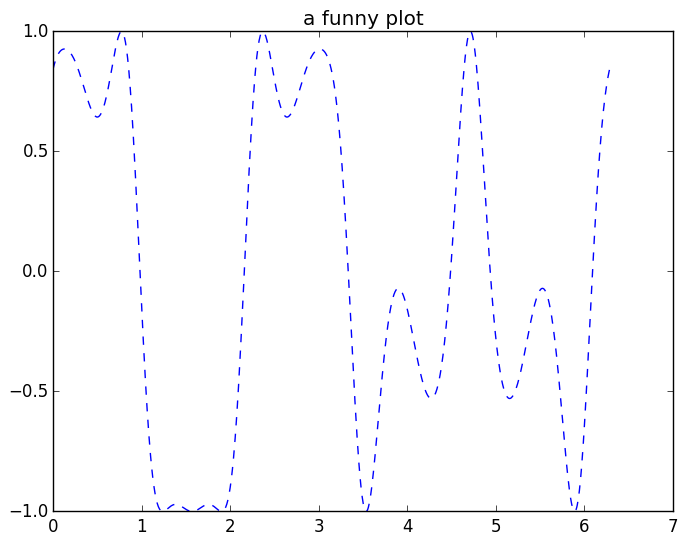

PyObject <matplotlib.text.Text object at 0x000000003680D240>

In [2]:
x = linspace(0,2π,1000)
y = sin(3x + cos(5x))
plot(x, y, "b--")
title("a funny plot")

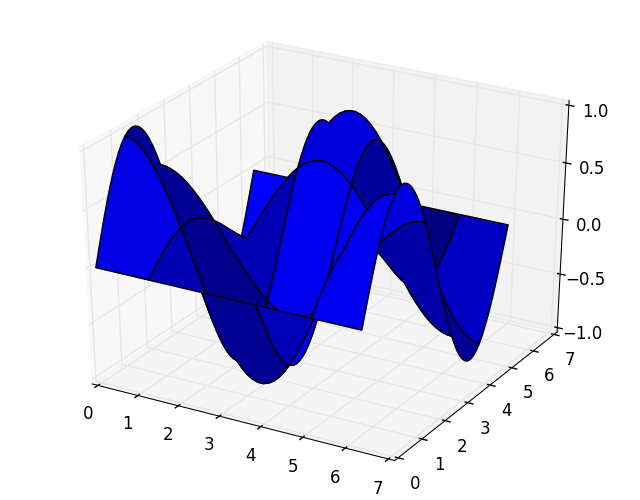

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x0000000036627668>

In [3]:
y = linspace(0,2π,50)
surf(y, y, sin(y) .* cos(y)')

We can also call seaborn from Julia using the **PyCall** package

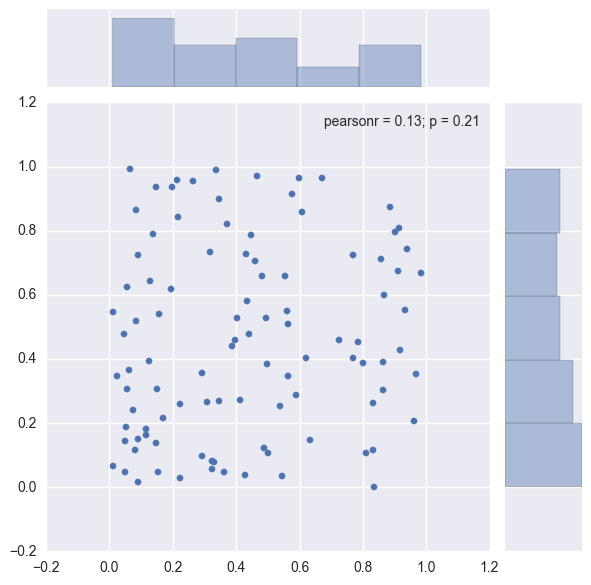

PyObject <seaborn.axisgrid.JointGrid object at 0x0000000043B88978>

In [7]:
@pyimport seaborn as sns
x = rand(100); y = rand(100)
sns.jointplot(x,y)

Really, the **whole Matplotlib API** is available for use.  It has everything you might want (in 2d, at least), if you dig long enough through the manuals:

In [5]:
#using PyCall, PyPlot
clf()
xkcd()
x = linspace(0,2π,1000)
fig = figure(figsize=(10,5))
ax = axes()
p = plot(x,sin(3x + cos(5x)))
ax[:set_xlim]([0.0,6])
annotate("A little\nsketchy",xy=[0.98,.001],arrowprops=["arrowstyle"=>"->"],xytext=[1.3,-0.3])

xticks([])
yticks([])
xlabel("TIME")
ylabel("PRODUCTIVITY")
title("An xkcd-style plot in Julia")

ax[:spines]["top"][:set_color]("none") # Remove the top axis boundary
ax[:spines]["right"][:set_color]("none") # Remove the right axis boundary


    close(Union(Integer,Figure,Symbol,String),) at C:\Users\jonathan\.julia\v0.3\PyPlot\src\PyPlot.jl:377
is ambiguous with: 
    close(Union(Integer,Figure,Symbol,String),) at C:\Users\jonathan\.julia\v0.3\PyPlot\src\PyPlot.jl:377.
To fix, define 
    close(Union(Integer,Symbol,String),)
before the new definition.
